# analysis of average face rating data

### import modules

In [1]:
import sys

import pandas as pd
from scipy import stats
import PIL

import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')

sys.path.append('../modules/')
import case_stats as cs

### show example stimuli

In [2]:
sns.set_style('dark')
stimFig = plt.figure(figsize=(14,4))
for i in range(1,6):
    ax = plt.subplot(1,5,i)
    im = PIL.Image.open('../faceAttract/experiment/stimuli/f001_00%s_cut.jpg' % i)
    ax.imshow(im)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel('%i faces' % (i*2),fontsize=30 )
plt.suptitle('Example Stimuli',fontsize=40,y=1.08)
plt.tight_layout()
plt.close()

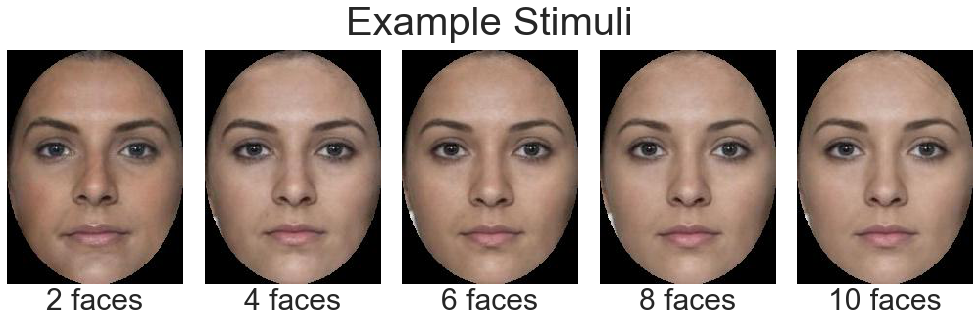

In [3]:
stimFig

### get the stimulus pairs corresponding to each code in unipark

each stimulus is a line of html code from which we need to extract the image names. The image names contain the information about the face identity (same for both pictures of pair) and the degree of averaging (from 1 to 5).

In [4]:
count = 0
with open('../faceAttract/experiment/data/codebook.csv','r') as f:
    for entry in f.readlines():
        print entry
        count+=1
        if count >1:
            break

Listenelement-Nr.;Metainformation;In Liste aufnehmen, wenn;Platzhalter 

1;<div style="text-align: center"><div style="display: inline-block"><img src="images/Stimuli/f001_002_cut.jpg" /></div>  <div style="display: inline-block"><div style="margin-right:40px"></div></div>  <div style="display: inline-block"><img src="images/Stimuli/f001_001_cut.jpg" /></div></div>;ist immer Listenelement;[1] <div style="text-align: center"><div style="display: inline-block"><img src="images/Stimuli/f001_002_cut.jpg" /></div>  <div style="display: inline-block"><div style="margin-right:40px"></div></div>  <div style="display: inline-block"><img src="images/Stimuli/f001_001_cut.jpg" /></div></div>



put the information into a table

In [5]:
stimList = pd.read_csv('../faceAttract/experiment/data/codebook.csv',index_col=[0],header=0,delimiter=';')

In [6]:
stimList.tail()

,Metainformation,"In Liste aufnehmen, wenn",Platzhalter
Listenelement-Nr.,,,
156,"<div style=""text-align: center""><div style=""di...",ist immer Listenelement,"[1] <div style=""text-align: center""><div style..."
157,"<div style=""text-align: center""><div style=""di...",ist immer Listenelement,"[1] <div style=""text-align: center""><div style..."
158,"<div style=""text-align: center""><div style=""di...",ist immer Listenelement,"[1] <div style=""text-align: center""><div style..."
159,"<div style=""text-align: center""><div style=""di...",ist immer Listenelement,"[1] <div style=""text-align: center""><div style..."
160,"<div style=""text-align: center""><div style=""di...",ist immer Listenelement,"[1] <div style=""text-align: center""><div style..."


extract the filename, and the morphing grade of left and right image

In [7]:
def getStimDf(stimList):
    d  = {}
    for i in stimList.index:
        thisDiv = stimList.loc[i].Metainformation
        #print thisDiv
        first = thisDiv[thisDiv.find('Stimuli/')+8:thisDiv.find('.jpg')]
        second = thisDiv[thisDiv.rfind('Stimuli/')+8:thisDiv.rfind('.jpg')]
        ident1,left = first.split('_')[:-1]
        ident2,right = second.split('_')[:-1]
        assert ident1==ident2
        d[i] = {'ident':ident1,'left':int(left),'right':int(right)}
    stimDf = pd.DataFrame(d).T
    return stimDf

In [8]:
stimDf = getStimDf(stimList)

In [9]:
stimDf.tail()

,ident,left,right
156,m008,2,4
157,m008,5,2
158,m008,3,4
159,m008,5,3
160,m008,4,5


### load data with participants' responses

In [10]:
dataDf = pd.read_csv('../faceAttract/experiment/data/attractData_2017_06_16.csv',delimiter=',',index_col=[0])

get rid of test data

In [11]:
dataDf = dataDf[dataDf.tester != 1]

get rid of participants with missing values

In [12]:
for i in range(1,161):
    thisCol = 'v_26_%s' % i
    dataDf = dataDf[dataDf[thisCol] != -77]
    
    thisCol = 'v_28_%s' % i
    dataDf = dataDf[dataDf[thisCol] != -77]

In [13]:
dataDf.shape

(62, 331)

In [14]:
dataDf.head()

,external_lfdn,tester,dispcode,lastpage,quality,duration,v_29,v_30,v_33,v_31,...,v_28_151,v_28_152,v_28_153,v_28_154,v_28_155,v_28_156,v_28_157,v_28_158,v_28_159,v_28_160
lfdn,,,,,,,,,,,,,,,,,,,,,
6,0,0,31,4178929,-77,2536,-77,-66,-77,-66,...,2,1,2,1,2,2,1,1,1,2
7,0,0,31,4178929,-77,2276,-77,-66,-77,-66,...,2,2,2,1,2,2,2,2,1,2
11,0,0,31,4178929,-77,2432,-77,-66,-77,-66,...,2,2,2,1,2,2,2,1,2,1
12,0,0,31,4178929,-77,2165,-77,-66,-77,-66,...,2,2,1,2,1,1,2,1,2,2
13,0,0,31,4178929,-77,1677,-77,-66,-77,-66,...,2,2,2,1,1,2,1,2,2,2


## demographics

### gender

In [15]:
genderDemoDf = pd.DataFrame()
count = dataDf.shape[0]
for i,label in zip([1,2,3,-77],['female','male','non-binary','missing']):
    thisSum = (dataDf.v_29 == i).sum()
    thisPercent = round(float(thisSum)/count*100,0)
    thisDict = {'sum':thisSum,'percent':thisPercent}
    thisDf = pd.DataFrame(thisDict,index=[label])
    genderDemoDf = pd.concat([genderDemoDf,thisDf])

In [16]:
genderDemoDf

,percent,sum
female,76.0,47
male,15.0,9
non-binary,0.0,0
missing,10.0,6


In [17]:
sns.set_style('darkgrid')

In [18]:
import numpy as np

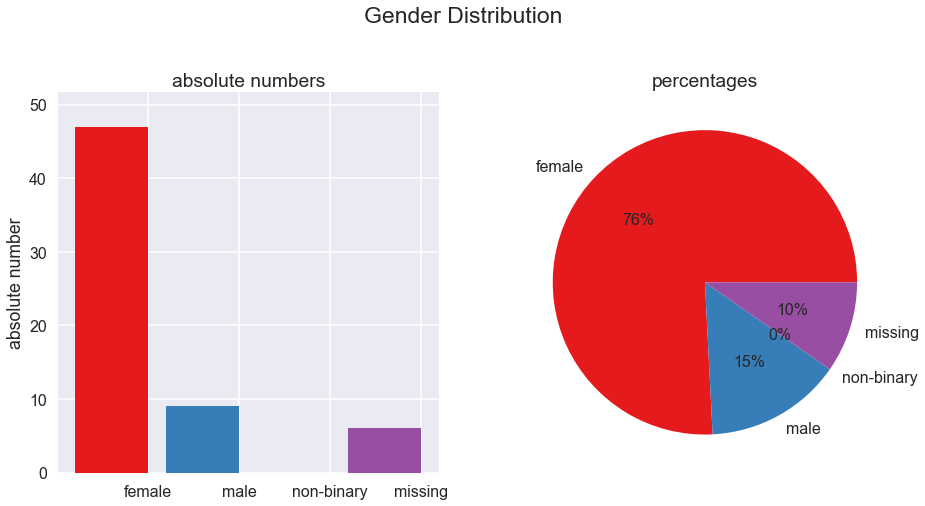

In [19]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))

ax1.bar(range(genderDemoDf.shape[0]),genderDemoDf['sum'],color=sns.color_palette('Set1',4))
ax1.set_ylabel('absolute number')
ax1.set_xticks(np.arange(genderDemoDf.shape[0])+0.4)
ax1.set_xticklabels(genderDemoDf.index)
ax1.set_ylim(0,genderDemoDf['sum'].max()*1.1)
ax1.set_title('absolute numbers')

ax2.pie(genderDemoDf['sum'],
        labels=genderDemoDf.index,
        colors=sns.color_palette('Set1',4),
        autopct='%1.0f%%',
        textprops={'fontsize':16});
ax2.set_title('percentages')
plt.suptitle('Gender Distribution',y=1.05)
plt.show()

### age

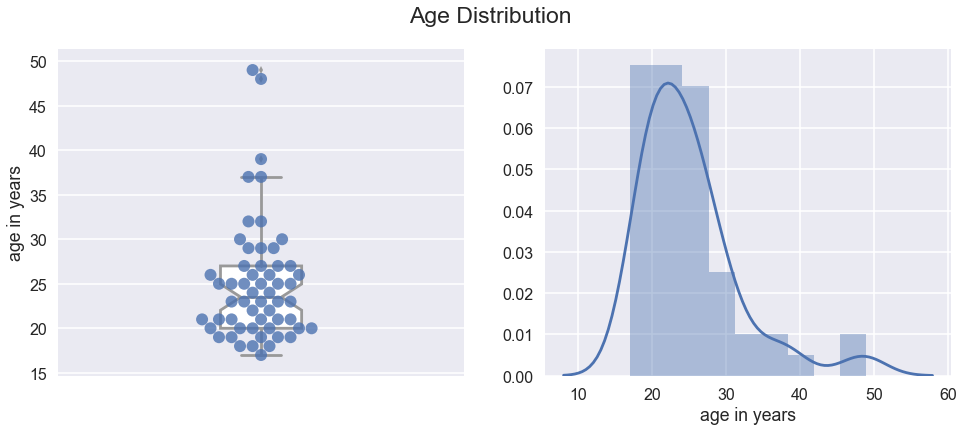

In [20]:
ageDf = pd.DataFrame( ( dataDf.v_31 != -66 ) * dataDf.v_31 )
ageDf.columns = ['age']
ageDf = ageDf[ageDf.age != 0]

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))

sns.boxplot(data=ageDf,color='white',width=0.2,notch=True,ax=ax1)
sns.swarmplot(data=ageDf,size=12,alpha=0.8,ax=ax1)
ax1.set_ylabel('age in years')
ax1.set_xticks([])
sns.distplot(ageDf,ax=ax2)
ax2.set_xlabel('age in years')
plt.suptitle('Age Distribution')
plt.show()

### drop all non-female participants

In [21]:
dataDf = dataDf[dataDf.v_29 == 1]

In [22]:
dataDf.shape

(47, 331)

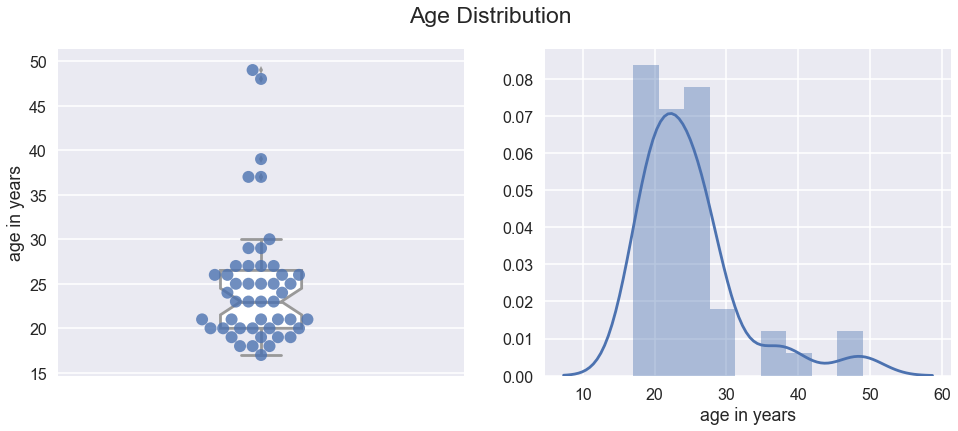

In [23]:
ageDf = pd.DataFrame( ( dataDf.v_31 != -66 ) * dataDf.v_31 )
ageDf.columns = ['age']
ageDf = ageDf[ageDf.age != 0]

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))

sns.boxplot(data=ageDf,color='white',width=0.2,notch=True,ax=ax1)
sns.swarmplot(data=ageDf,size=12,alpha=0.8,ax=ax1)
ax1.set_ylabel('age in years')
ax1.set_xticks([])
sns.distplot(ageDf,ax=ax2)
ax2.set_xlabel('age in years')
plt.suptitle('Age Distribution')
plt.show()

In [24]:
print ageDf.age.min(),ageDf.age.max(),round(ageDf.age.mean(),0)

17 49 25.0


## Extract all relevant information for the main paradigm

one example participant to run the analyses for

In [25]:
pNum = dataDf.index[0]

In [26]:
pNum

90

### get answers to all stimuli of one condition

In [27]:
def collectAns(pNum,dataDf,cond):
    dataDict = {}
    for entry in dataDf.columns:
        # cond 'v_26' attract;  cond 'v_28' symp;
        if cond in entry:
            num = entry.split('_')[-1]
            dataDict[num] = int(dataDf.loc[pNum][entry])
    thisDf = pd.DataFrame(dataDict,index=['ans']).T
    thisDf.index = [int(x) for x in thisDf.index]
    thisDf = thisDf.sort_index()
    
    return thisDf

In [28]:
thisAns = collectAns(pNum,dataDf,'v_26')

thisAns tells us for one conditon (attract or likability) if the left image (1) or the right image (2) was chosen

In [29]:
thisAns.tail()

,ans
156,2
157,1
158,2
159,1
160,2


### concatenate stimulus names and answers

In [30]:
ansDf = pd.concat([stimDf,thisAns],axis=1)

In [31]:
ansDf.tail()

,ident,left,right,ans
156,m008,2,4,2
157,m008,5,2,1
158,m008,3,4,2
159,m008,5,3,1
160,m008,4,5,2


### recode answers to indicate if more average face was prefered

In [32]:
def getHits(ansDf):
    cpDf = ansDf.copy()
    leftBigger = cpDf['left']>cpDf['right']
    rightBigger = cpDf['right']>cpDf['left']

    leftAns = cpDf['ans'] == 1
    rightAns = cpDf['ans'] == 2

    cpDf['hit'] = (rightBigger & rightAns) | (leftBigger & leftAns)
    return cpDf

In [33]:
hitDf = getHits(ansDf)

here, a hit means that the hypothesis-congruent behavior (choosing the more strongly averaged face) was exhibited

In [34]:
hitDf.tail()

,ident,left,right,ans,hit
156,m008,2,4,2,True
157,m008,5,2,1,True
158,m008,3,4,2,True
159,m008,5,3,1,True
160,m008,4,5,2,True


### count the hits

In [35]:
def makeHits(pNum,dataDf,cond):
    thisAns = collectAns(pNum,dataDf,cond)
    ansDf = pd.concat([stimDf,thisAns],axis=1)
    ansDf = getHits(ansDf)

    percentHits = float( ansDf.hit.sum() ) / ansDf.hit.size * 100

    return percentHits

### count the hits for both attractivity and likability

In [36]:
def makeParticipant(pNum,dataDf):
    d = {}
    # attraktive 26
    # sympathetic 28
    attr = makeHits(pNum,dataDf,'v_26')
    symp = makeHits(pNum,dataDf,'v_28')
    d = {'attractiveness':attr,'likability':symp}
    df = pd.DataFrame(d,index=[pNum])
    return df

In [37]:
makeParticipant(pNum,dataDf)

,attractiveness,likability
90,72.5,73.125


### do this for all participants

In [38]:
def makeAll(dataDf):
    bigDf = pd.DataFrame()
    for pNum in dataDf.index:
        thisDf = makeParticipant(pNum,dataDf)
        bigDf = pd.concat([bigDf,thisDf])
    return bigDf

In [39]:
bigDf = makeAll(dataDf)

In [40]:
bigDf.to_csv('../faceAttract/output/mainResults.csv')

### raw data

In [41]:
raw_df = bigDf.loc[[312]].T
raw_df.columns = ['% correct']
raw_df

,% correct
attractiveness,76.875
likability,43.750


### percentile score

In [42]:
percentile_df = cs.make_percentile_df(bigDf,312)
percentile_df

,percentile,z
attractiveness,64.379177,0.368613
likability,0.039227,-3.358192


### ttest results

In [43]:
ttest_df = cs.make_tstats_df(bigDf,312)
ttest_df

,t,df,p
attractiveness,0.36,45,0.720
likability,-3.29,45,0.002


### save everything in one table

In [44]:
result_df = pd.concat([raw_df, percentile_df, ttest_df],axis=1)
# add hierarchy to index
result_df.index = [['Face evaluation']*result_df.shape[0], [x[0].upper()+x[1:] for x in result_df.index] ]
result_df

% correct  percentile         z      t  df  \
Face evaluation Attractiveness     76.875   64.379177  0.368613   0.36  45   
                Likability         43.750    0.039227 -3.358192  -3.29  45   

                                    p  
Face evaluation Attractiveness  0.720  
                Likability      0.002

Save to file

In [45]:
result_df.to_csv('../reports/tables/faceattract_main_results.csv')

### plot the average response

In [46]:
sns.set_style('white')

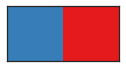

In [47]:
sns.set_palette(sns.color_palette('Set1',2)[::-1])
myPalette = sns.color_palette('Set1',2)[::-1]
sns.palplot(myPalette)

In [48]:
snsDf = pd.DataFrame( bigDf.stack() )
snsDf['cond'] = [ snsDf.index.levels[1][x] for x in snsDf.index.labels[1] ]
snsDf['group'] = [['controls','JB'][snsDf.index.levels[0][x]==312] for x in snsDf.index.labels[0] ]
snsDf.columns = ['% preference for more average face','','group']

In [49]:
swarmFig,ax = plt.subplots(1,1,figsize=(8,6))
sns.swarmplot(data=snsDf,x='',y='% preference for more average face',hue='group',
              size=16,orient='v',edgecolor='white',linewidth=1,alpha=0.8,ax=ax)

plt.axhline(50,linewidth=1,color='k',linestyle='dashed')
plt.ylim(0,100)
plt.title('Average attractiveness and likability ratings')
plt.legend(loc='lower right')
sns.despine()
plt.close()

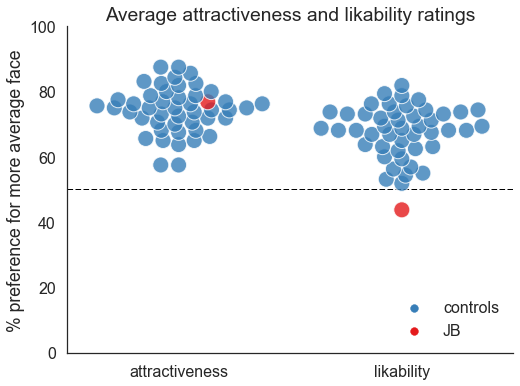

In [50]:
swarmFig

In [51]:
from PIL import Image

In [52]:
stimFig.savefig('../faceAttract/output/stimFig.png',bbox_inches='tight',dpi=300)
swarmFig.savefig('../faceAttract/output/swarmFig.png',bbox_inches='tight',dpi=300)

In [53]:
sns.set_style('dark')

In [54]:
msFig,(ax1,ax2) = plt.subplots(2,1)

ax1 = plt.subplot2grid((10, 1), (0, 0),rowspan=3)
ax1.imshow( Image.open('../faceAttract/output/stimFig.png','r') )
ax1.set_xticks([]);ax1.set_yticks([])

ax2 = plt.subplot2grid((10, 1), (3, 0),rowspan=7 )
ax2.imshow( Image.open('../faceAttract/output/swarmFig.png','r'))
ax2.set_xticks([]);ax2.set_yticks([])
plt.tight_layout()

plt.close()

In [55]:
msFig.savefig('../reports/figures/attract_main_figure.png',bbox_inches='tight',dpi=300)

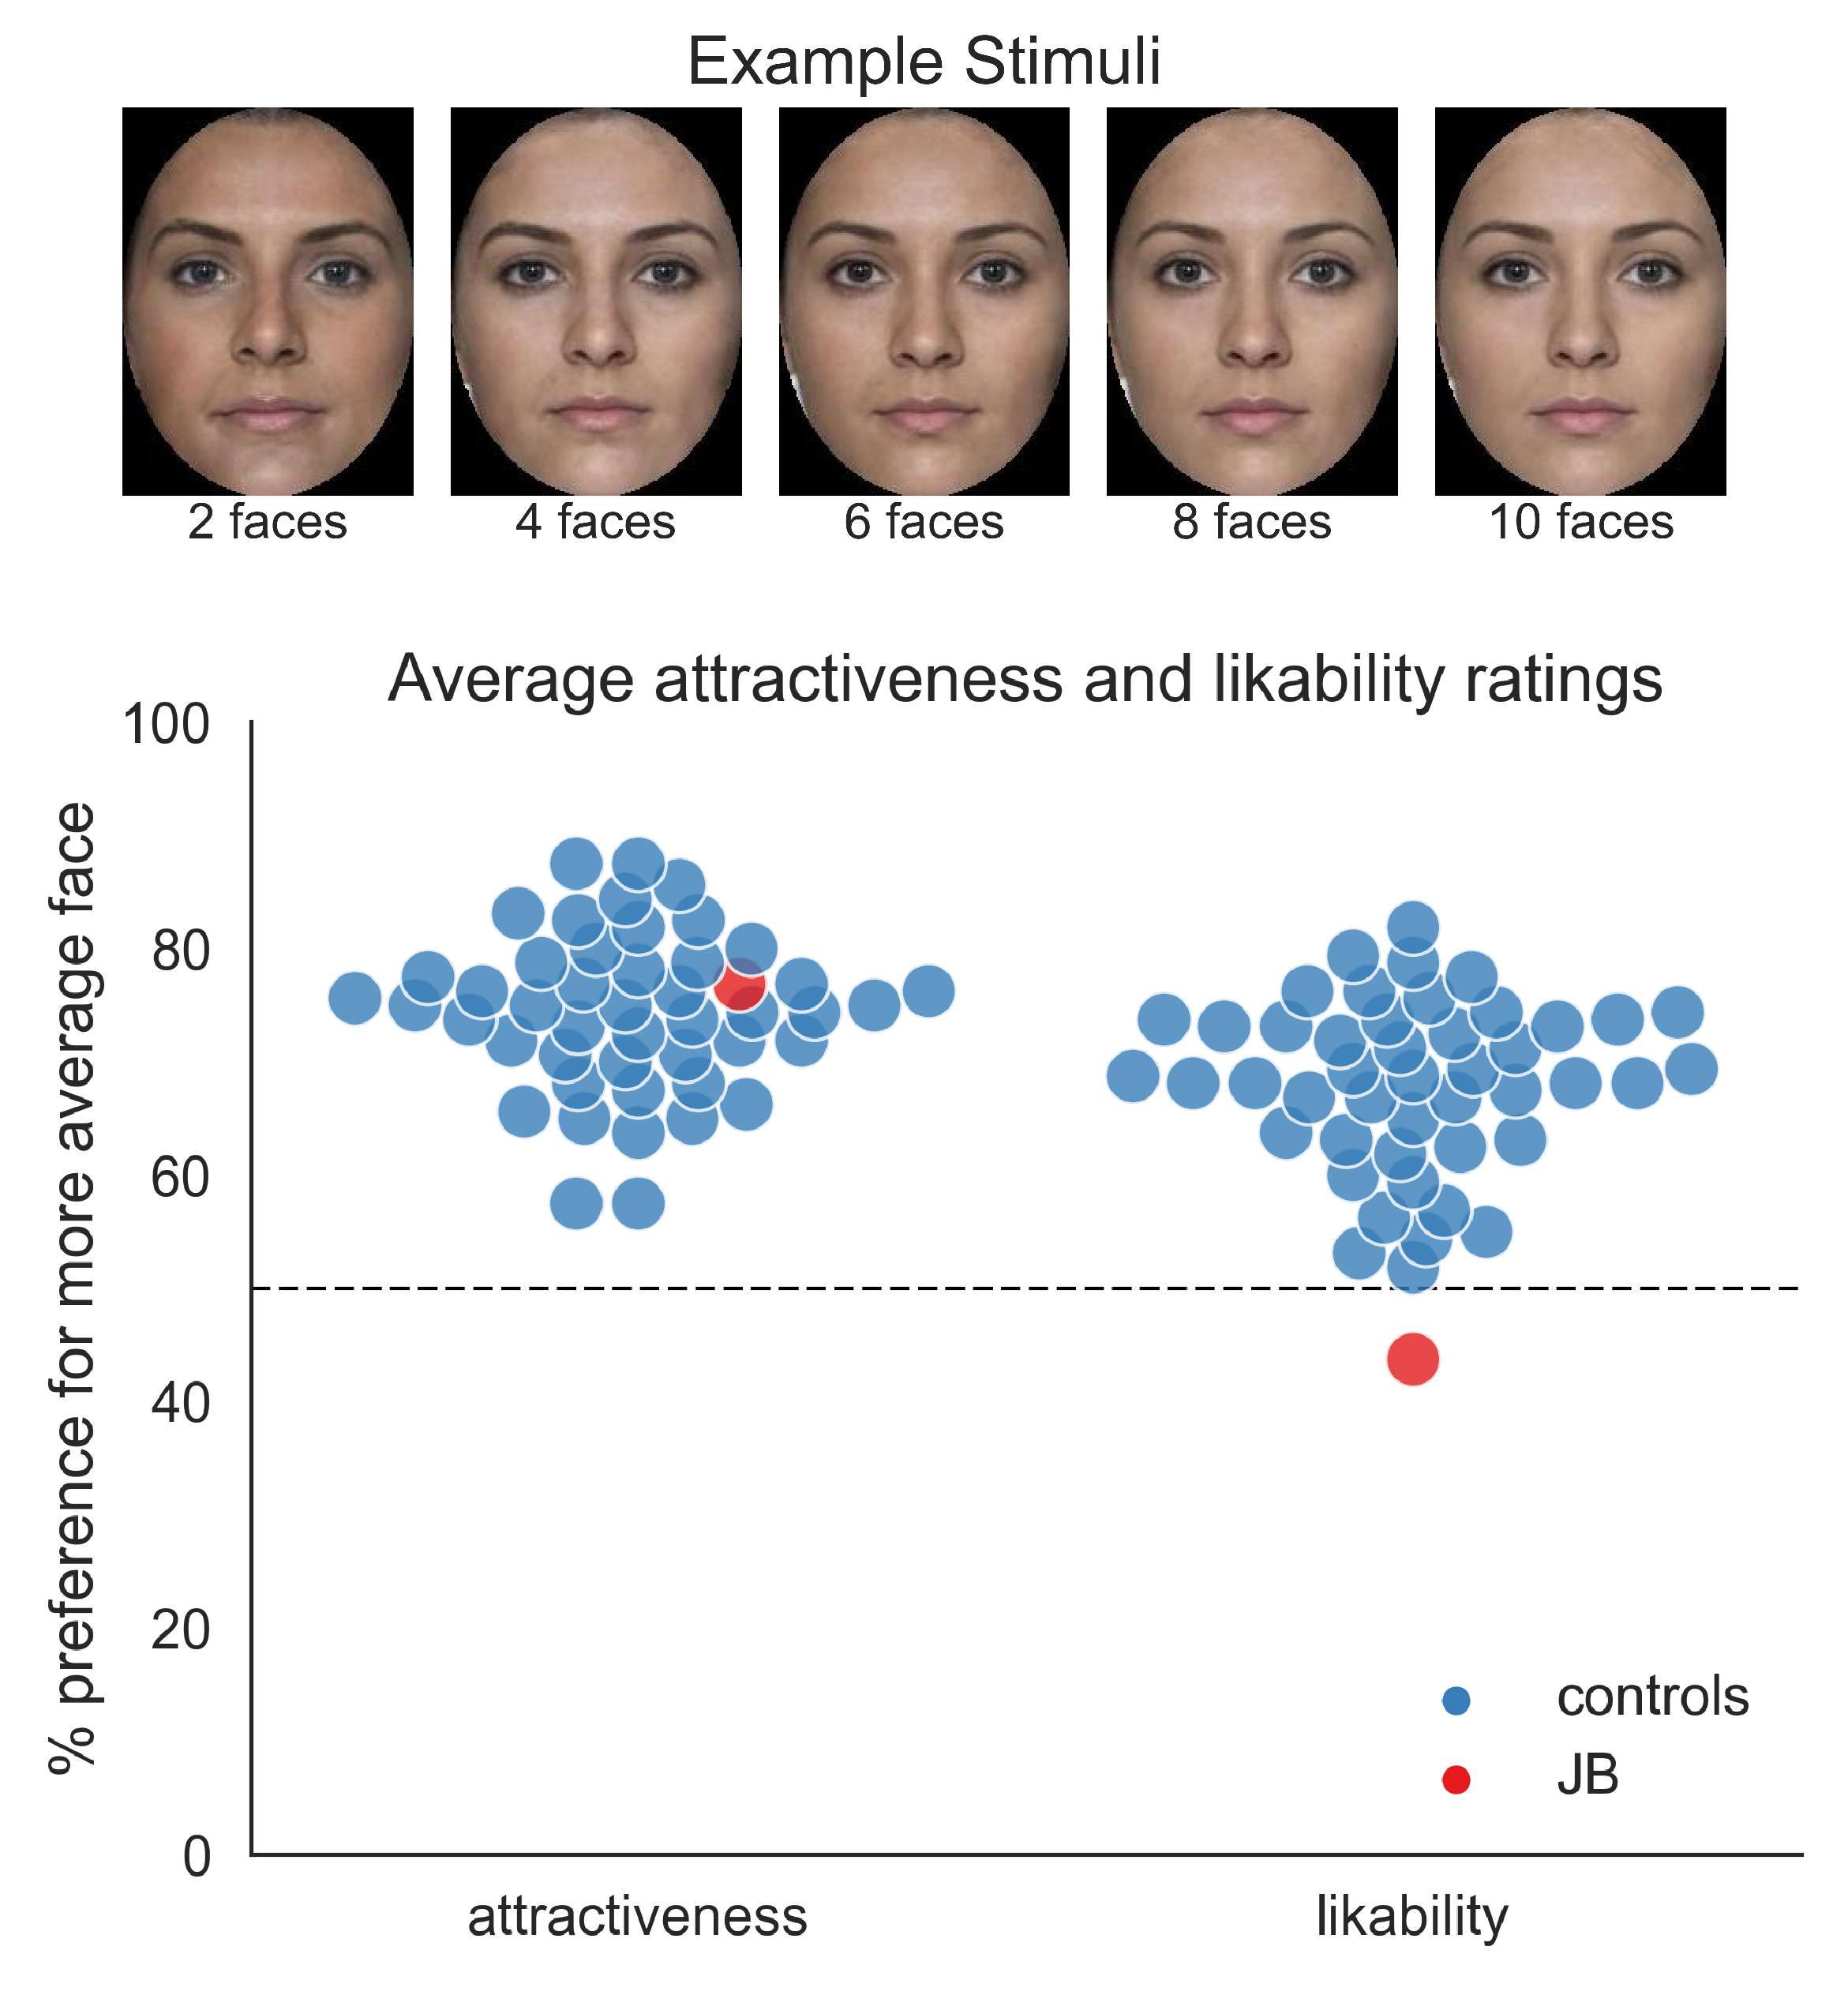

In [56]:
PIL.Image.open('../reports/figures/attract_main_figure.png')

### analysis for all 10 possible pairings of averaged faces

get hits for one pair

In [57]:
def makePairs(df,a,b):

    # find all instances with a and b (e.g. 1 and 2)
    df['%s-%s' % (a,b)] = ((df['left'] == a) & (df['right'] == b)) | ((df['left'] == b) & (df['right'] == a))
    # get all hits for this pair (conventiently, hits have already been computed before for the more general case)
    df['hit %s-%s' % (a,b)] = (df['%s-%s' % (a,b)] == True) & (df['hit'] == True)
    
    return df

loop through all possible pairings

In [58]:
def makeAllPairs(pNum,dataDf,cond,stimDf=stimDf):
    
    thisAns = collectAns(pNum,dataDf,cond)
    ansDf = pd.concat([stimDf,thisAns],axis=1)
    hitDf = getHits(ansDf)
    
    #make all possible (and impossible...) pairs
    for i in range(1,6):
        for j in range(1,6):
            hitDf = makePairs(hitDf,i,j)
    
    # compute percent hits  
    d = {}
    count = 0
    for i in range(1,6):
        for j in range(1,6):
            try:
                thisPercent = float( hitDf['hit %s-%s' % (i,j)].sum() ) / hitDf['%s-%s' % (i,j)].sum() * 100
                d[count] = {'lower':i,'higher':j,'hit':thisPercent}
                count +=1
            except:
                pass
                #print i,j

    # turn into matrix-shaped df
    df = pd.DataFrame(d).T
    df.index = [df.lower,df.higher]
    df.drop('lower',inplace=True,axis=1)
    df.drop('higher',inplace=True,axis=1)
    df = df.T
    df.index = [pNum]
    return df

example:

In [59]:
makeAllPairs(312,dataDf,'v_26')

lower    1.0                       2.0                       3.0               \
higher   2.0   3.0    4.0    5.0   1.0    3.0    4.0   5.0   1.0    2.0   4.0   
312     87.5  87.5  93.75  93.75  87.5  68.75  81.25  62.5  87.5  68.75  75.0   

lower           4.0                        5.0                     
higher   5.0    1.0    2.0   3.0    5.0    1.0   2.0   3.0    4.0  
312     50.0  93.75  81.25  75.0  68.75  93.75  62.5  50.0  68.75

### do this for all participants

In [60]:
def makeAllPairsForAll(dataDf,cond):
    bigDf = pd.DataFrame()
    for pNum in dataDf.index:
        thisDf = makeAllPairs(pNum,dataDf,cond)
        bigDf = pd.concat([bigDf,thisDf])
    return bigDf

here, this is done for one condition (v_26 is attractivity)

In [61]:
bigPairDf = makeAllPairsForAll(dataDf,'v_26')

In [62]:
bigPairDf.tail()

lower     1.0                            2.0                          3.0  \
higher    2.0     3.0     4.0     5.0    1.0    3.0    4.0    5.0     1.0   
361     75.00   87.50   93.75   93.75  75.00  62.50  81.25  62.50   87.50   
362     81.25   87.50   87.50   93.75  81.25  43.75  56.25  43.75   87.50   
363     87.50  100.00  100.00  100.00  87.50  68.75  75.00  81.25  100.00   
365     81.25   81.25   81.25   75.00  81.25  87.50  81.25  75.00   81.25   
366     87.50   81.25   87.50   87.50  87.50  68.75  68.75  75.00   81.25   

lower                          4.0                          5.0               \
higher    2.0    4.0   5.0     1.0    2.0    3.0    5.0     1.0    2.0   3.0   
361     62.50  50.00  75.0   93.75  81.25  50.00  56.25   93.75  62.50  75.0   
362     43.75  62.50  50.0   87.50  56.25  62.50  68.75   93.75  43.75  50.0   
363     68.75  75.00  62.5  100.00  75.00  75.00  37.50  100.00  81.25  62.5   
365     87.50  50.00  50.0   81.25  81.25  50.00  81.25   75.00  75.00  50.0   
366     68.75  43.75  75.0   87.50  68.75  43.75  56.25   87.50  75.00  75.0   

lower          
higher    4.0  
361     56.25  
362     68.75  
363     37.50  
365     81.25  
366     56.25

### plot the mean heatmap (group average)

In [63]:
meanMatrixDf = pd.DataFrame( bigPairDf.mean() ).unstack(0)[0]

In [64]:
meanMatrixDf = meanMatrixDf.loc[meanMatrixDf.index[1:]][meanMatrixDf.columns[:-1]]

In [65]:
meanMatrixDf

lower,1.0,2.0,3.0,4.0
higher,,,,
2.0,86.436170,NaN,67.420213,75.930851
3.0,90.159574,67.420213,NaN,60.505319
4.0,92.154255,75.930851,60.505319,NaN
5.0,89.228723,73.271277,55.718085,53.058511


mask out all redundant data above the diagnal (including the diagnoal)

In [66]:
def makeMatrixMask(matrixDf):
    mask = matrixDf.mask(np.triu(np.ones(matrixDf.shape)).astype(np.bool))
    mask[abs(mask)>0] = False
    mask[abs(mask)!=0.] = True
    return abs(1-np.array(mask).T)

In [67]:
makeMatrixMask(meanMatrixDf)

array([[ 0.,  1.,  1.,  1.],
       [ 0.,  0.,  1.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.]])

### heatmap plot

In [68]:
def matrixPlot(dataDf,cond,ax):
    
    if cond == 'v_26':
        myTitle = 'attractiveness'
    elif cond == 'v_28':
        myTitle = 'likability'
    else:
        print 'wrong condition!'
        
    bigPairDf = makeAllPairsForAll(dataDf,cond)
    meanMatrixDf = pd.DataFrame( bigPairDf.mean() ).unstack(0)[0]
    meanMatrixDf = meanMatrixDf.loc[meanMatrixDf.index[1:]][meanMatrixDf.columns[:-1]]
    
    mask = makeMatrixMask(meanMatrixDf)
    
    sns.heatmap( meanMatrixDf,mask=mask,
                 square=True,vmin=0,vmax=100,cmap='RdBu_r',annot=True,ax=ax )
    ax.set_xticks(np.arange(4)+0.5)
    ax.set_xticklabels(range(2,9,2))
    
    ax.set_yticks(np.arange(4)+0.5)
    ax.set_yticklabels(range(10,3,-2))
    
    ax.set_title(myTitle)
    
    return ax

### Figure for all controls

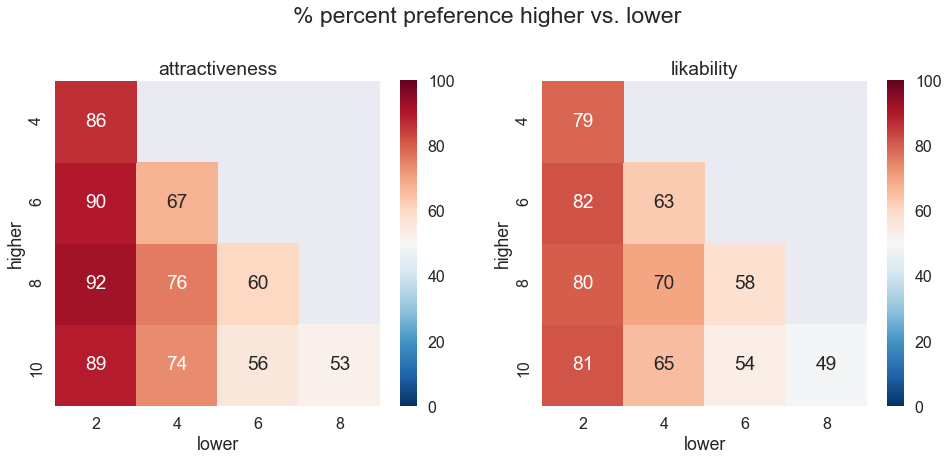

In [69]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
ax1 = matrixPlot(dataDf.drop(312),'v_26',ax1)
ax2 = matrixPlot(dataDf.drop(312),'v_28',ax2)
plt.suptitle('% percent preference higher vs. lower',y=1.05)
plt.show()

### Figure for JB

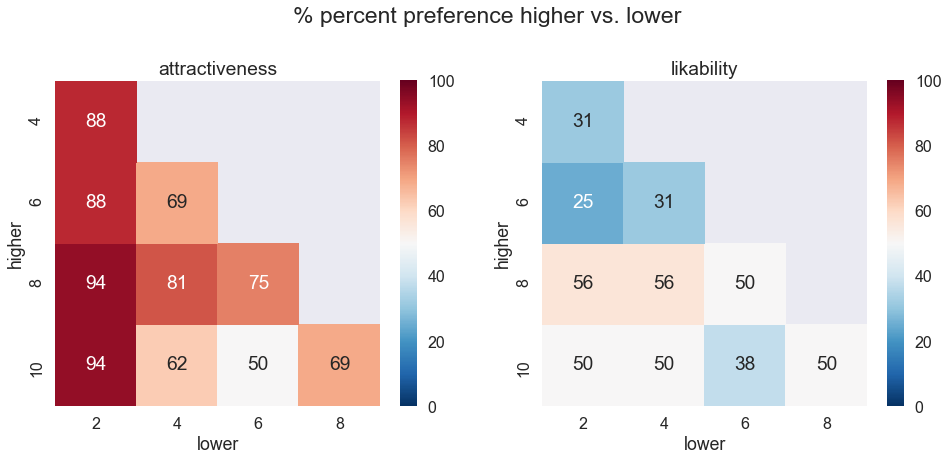

In [70]:
thisDf = pd.DataFrame( dataDf.loc[312] ).T
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
ax1 = matrixPlot(thisDf,'v_26',ax1)
ax2 = matrixPlot(thisDf,'v_28',ax2)
plt.suptitle('% percent preference higher vs. lower',y=1.05)
plt.show()

### differential rating of male and female faces

count hits when splitting the dataframe by face gender

In [71]:
def makeGenderAns(pNum,dataDf,cond):
    # extract answers
    thisAns = collectAns(pNum,dataDf,cond)
    ansDf = pd.concat([stimDf,thisAns],axis=1)
    fuDf = getHits(ansDf)

    # group into female,male
    fuDf['group'] = [['male','female'][x[0]=='f'] for x in fuDf.ident]
    # get percent hits
    thisHits = pd.DataFrame( fuDf.groupby('group').sum()['hit'] ).T
    thisCount = pd.DataFrame( fuDf.groupby('group').count()['hit'] ).T
    thisDf = thisHits/thisCount * 100
    thisDf.index = [pNum]
    return thisDf

example for one participant:

In [72]:
thisDf = makeGenderAns(pNum,dataDf,'v_26')

In [73]:
thisDf

group,female,male
90,78.75,66.25


do this for both conditions (attractivity and likability)

In [74]:
def makeAllGenderConds(pNum,dataDf):
    bothDf = pd.DataFrame()
    for label,num in [('attractiveness','v_26'),('likability','v_28')]:
        thisDf = makeGenderAns(pNum,dataDf,num)
        thisDf.columns = [[label]*thisDf.shape[1],thisDf.columns]
        
        bothDf = pd.concat([bothDf,thisDf],axis=1)
    return bothDf

In [75]:
makeAllGenderConds(pNum,dataDf)

attractiveness        likability       
group         female   male     female   male
90             78.75  66.25       75.0  71.25

### do this for all participants

In [76]:
def makeAllParticipantsAllGender(dataDf):
    bigDf = pd.DataFrame()
    for pNum in dataDf.index:
        thisDf = makeAllGenderConds(pNum,dataDf)
        bigDf = pd.concat([bigDf,thisDf],axis=0)
    return bigDf

In [77]:
genderDf = makeAllParticipantsAllGender(dataDf)

In [78]:
genderDf['group'] = [['controls','JB'][x == 312] for x in genderDf.index]

In [79]:
genderDf.tail()

attractiveness        likability            group
group         female   male     female   male          
361            80.00  67.50      72.50  66.25  controls
362            66.25  68.75      70.00  55.00  controls
363            77.50  80.00      78.75  70.00  controls
365            77.50  71.25      68.75  58.75  controls
366            83.75  62.50      71.25  63.75  controls

### plot gender effects

In [80]:
def makeGenderSns(genderDf,cond,ax):
    
    thisDf = genderDf[cond]

    stackDf = pd.DataFrame( thisDf.stack() )
    stackDf['face'] = [stackDf.index.levels[1][x] for x in stackDf.index.labels[1] ]
    idx = [stackDf.index.levels[0][x] for x in stackDf.index.labels[0]]
    stackDf['group'] = [['controls','JB'][x == 312] for x in idx]
    stackDf.columns = ['% preference', 'face gender','group']

    sns.boxplot(data=stackDf,x='face gender',y='% preference',color='white',notch=True,width=0.5,ax=ax)
    sns.swarmplot(data=stackDf,x='face gender',y='% preference',hue='group',ax=ax,
                  size=14,orient='v',edgecolor='white',linewidth=1,alpha=0.8)

    ax.axhline(50,linewidth=1,color='k')
    ax.set_ylim(0,100)
    ax.set_title(cond)
    
    return ax

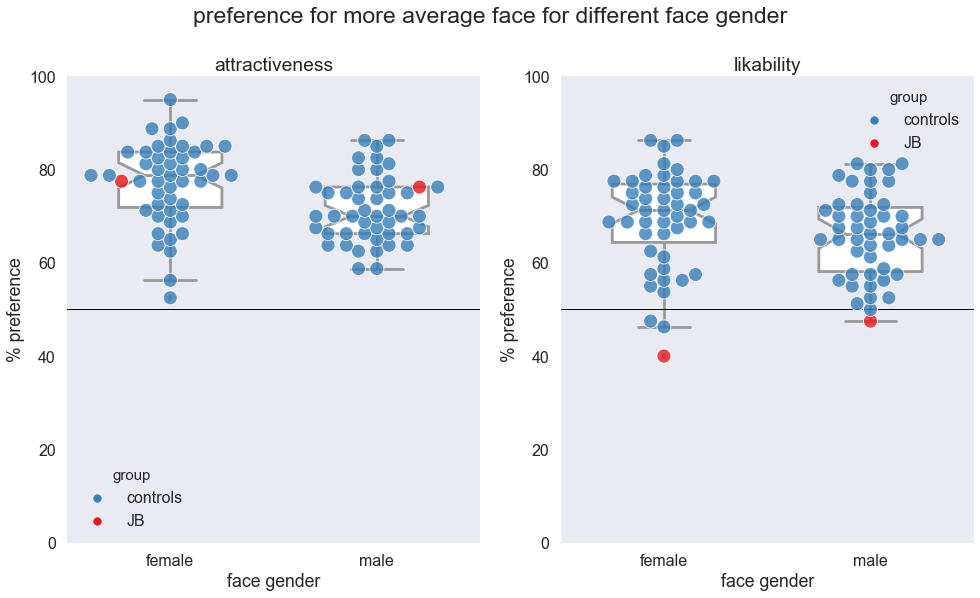

In [81]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,8))
ax1 = makeGenderSns(genderDf,'attractiveness',ax1)
ax2 = makeGenderSns(genderDf,'likability',ax2)
plt.suptitle('preference for more average face for different face gender',y=1.05)
plt.tight_layout()
plt.show()